# IBM Data Science Capstone Project

### Adam Herrman

## Description

We are planning a trip to Charlotte, North Carolina. We want to know where the hottest place to visit in the city is.

## Install Packages

In [1]:
!pip install geopy
!pip install beautifulsoup4
!pip install lxml
!pip install folium

print('Packages Installed')

     |████████████████████████████████| 94 kB 6.1 MB/s  eta 0:00:01
Packages Installed


## Import Libraries

In [123]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import requests
import random
import folium
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim

print('Libraries Imported')

Libraries Imported


## Get coordinates of Charlotte NC

In [3]:
address = 'Charlotte, NC'

geolocator = Nominatim(user_agent='Charlotte')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Charlotte are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Charlotte are 35.2272086, -80.8430827.


## Set up Foursquar connectin string

In [4]:
CLIENT_ID = '4C4BVF1O4QPSUF5UZF0T5G0ZJK1EO2YMYH0WMEVJNH40B0BP' # your Foursquare ID
CLIENT_SECRET = 'BD2N4X5POWLNH5UJCN3UXF0TG0ZYHVTFY2JP4TGPZMXNIL4R' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4C4BVF1O4QPSUF5UZF0T5G0ZJK1EO2YMYH0WMEVJNH40B0BP
CLIENT_SECRET:BD2N4X5POWLNH5UJCN3UXF0TG0ZYHVTFY2JP4TGPZMXNIL4R


## Search for venues within price range

In [6]:
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius in meters
price_lvl = '1,2'


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&price={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude,
    radius,
    LIMIT,
    price_lvl)

results = requests.get(url).json()

In [7]:
%tore results

Stored 'results' (dict)


In [8]:
#filter json
venues = results['response']['groups'][0]['items']
    
# flatten JSON
venues = json_normalize(venues) 

# filter columns
filtered_columns = ['venue.id', 'venue.name', 'venue.location.lat', 'venue.location.lng']
venues = venues.loc[:, filtered_columns]

# clean columns
venues.columns = [col.split(".")[-1] for col in venues.columns]

venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,id,name,lat,lng
0,4e2ffb921838f1c552ca5f70,Vapiano,35.226234,-80.844124
1,4bb14a46f964a520fa893ce3,Aria Tuscan Grill,35.226615,-80.842317
2,4b466381f964a5206f1f26e3,Dandelion Market,35.228656,-80.842479
3,55a42c96498e793e0e13b18c,The Cellar,35.229240,-80.839710
4,576eb02b498e5c4439a993cd,Not Just Coffee,35.226891,-80.846126


## Use an elbow curve to determine the optimal number of clusters for k-mean clustering

In cluster analysis, the elbow method is a heuristic used in determining the optimal number of clusters in a data set.

In [9]:
# Get the coordinates of each venue returned by our search.
df_coord = venues[['id', 'lat', 'lng', 'name']]
df_coord.dropna(axis=0,how='any',subset=['lat','lng'],inplace=True)
df_coord.head()

,id,lat,lng,name
0,4e2ffb921838f1c552ca5f70,35.226234,-80.844124,Vapiano
1,4bb14a46f964a520fa893ce3,35.226615,-80.842317,Aria Tuscan Grill
2,4b466381f964a5206f1f26e3,35.228656,-80.842479,Dandelion Market
3,55a42c96498e793e0e13b18c,35.229240,-80.839710,The Cellar
4,576eb02b498e5c4439a993cd,35.226891,-80.846126,Not Just Coffee


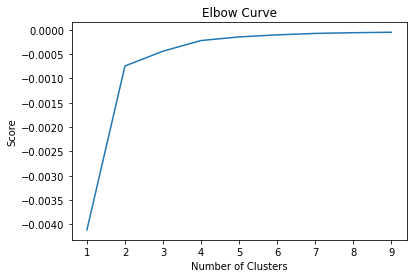

In [10]:
# Fit the clustering model to our coordinate data
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df_coord[['lat']]
X_axis = df_coord[['lng']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualize the elbow curve with MatPlotLib
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

I will choose 5 clusters based on the elbow curve

## Perform K-Mean clustering for our search results in Charlotte NC

In [11]:
kmeans = KMeans(n_clusters = 5, init ='k-means++')
kmeans.fit(df_coord[df_coord.columns[1:3]]) # Compute k-means clustering.
df_coord['cluster_label'] = kmeans.fit_predict(df_coord[df_coord.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(df_coord[df_coord.columns[1:3]]) # Labels of each point
print(df_coord.head())

print('df shape')
print(df_coord.shape)

print('cluster centers')
print(centers)

                         id        lat        lng               name  \
0  4e2ffb921838f1c552ca5f70  35.226234 -80.844124            Vapiano   
1  4bb14a46f964a520fa893ce3  35.226615 -80.842317  Aria Tuscan Grill   
2  4b466381f964a5206f1f26e3  35.228656 -80.842479   Dandelion Market   
3  55a42c96498e793e0e13b18c  35.229240 -80.839710         The Cellar   
4  576eb02b498e5c4439a993cd  35.226891 -80.846126    Not Just Coffee   

   cluster_label  
0              4  
1              4  
2              4  
3              4  
4              4  
df shape
(87, 5)
cluster centers
[[ 35.21695313 -80.85420957]
 [ 35.21368823 -80.83351362]
 [ 35.22760503 -80.82417577]
 [ 35.23056105 -80.86016398]
 [ 35.2274064  -80.8440707 ]]


## Visualize the clusters of venues in Charlotte with Folium

In [109]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14,width=1300,height=600)

# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
marker_colors = ['red','green','blue','yellow','orange']
for lat, lon, cluster in zip(df_coord['lat'], df_coord['lng'], df_coord['cluster_label']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## find the cluster with the largest number of venues

In [14]:
df_venue_count = df_coord[['cluster_label']].groupby('cluster_label').size()
df_venue_count

cluster_label
0    26
1    22
2     6
3     4
4    29
dtype: int64

## The cluster in Charlotte Uptown has the largest number of venues, we will visit there.

In [15]:
df_cluster_venues = df_coord[ df_coord['cluster_label']==df_venue_count.idxmax()]
df_cluster_venues = df_cluster_venues[['id']] # creat a list of the id#s in each venue in the chosen cluster
df_cluster_venues.head()

,id
0,4e2ffb921838f1c552ca5f70
1,4bb14a46f964a520fa893ce3
2,4b466381f964a5206f1f26e3
3,55a42c96498e793e0e13b18c
4,576eb02b498e5c4439a993cd


## Define a function to retrieve venue details from Foursquare

In [18]:
def venue_details_query(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
    venue_id,
    '4C4BVF1O4QPSUF5UZF0T5G0ZJK1EO2YMYH0WMEVJNH40B0BP',
    'BD2N4X5POWLNH5UJCN3UXF0TG0ZYHVTFY2JP4TGPZMXNIL4R',
    VERSION)
    json = requests.get(url).json()
    return json

## Define a function to exract the relavent attibutes from the Foursquare json files

The function must be able to deal with missing information, such as, missing descriptions or addresses

In [102]:
def extract_venue_details(json):
    
    results = json['response']['venue'] #filter on JSON data with the response.venue attribute
    search_keys = ['id','name','rating','likes','categories', 'description','location']
    filtered_dict = {}
    address_str = ""
    category_lst = []
    category_str = ""

    for key in search_keys:
        try:
            filtered_dict[key] =results[key]
        except:
            pass
    
    try:
        filtered_dict['likes'] = filtered_dict['likes']['count'] #extract the venue's number of likes
    except:
        pass
    
    try:
        filtered_dict['location'] = address_str.join(filtered_dict['location']['formattedAddress']) #Extract the venue's address and convert to string
    except:
        pass
    
    try:
        for category in filtered_dict['categories']: #extract venue's category names and convert to a string
            category_lst.append(category['name'].lower())
        filtered_dict['categories'] = category_str.join(category_lst)
    except:
        pass
    
    return filtered_dict

## Retrieve the Frousquare search results as json files for each venue in the Charlotte Uptown cluster as json files

In [20]:
id_lst = df_cluster_venues['id'].tolist() #convert the df_cluster_venues to a list of IDs
venue_details_jsons = []

for venue_id in id_lst:
    json = venue_details_query(venue_id) # retrieve the details for each venue as a json file
    venue_details_jsons.append(json) # create a list containing all the json files

In [21]:
%store venue_details_jsons
venue_details_jsons

Stored 'venue_details_jsons' (list)


[{'meta': {'code': 200, 'requestId': '5fff3a0509586a1e9c219a51'},
  'response': {'venue': {'id': '4e2ffb921838f1c552ca5f70',
    'name': 'Vapiano',
    'contact': {'phone': '7043322440',
     'formattedPhone': '(704) 332-2440',
     'twitter': 'vapianoclt',
     'facebook': '198352626866393',
     'facebookUsername': 'BellaCiaoCLT',
     'facebookName': 'The Bella Ciao'},
    'location': {'address': '201 S Tryon St',
     'crossStreet': 'E 4th St',
     'lat': 35.226234166101676,
     'lng': -80.84412438023452,
     'labeledLatLngs': [{'label': 'display',
       'lat': 35.226234166101676,
       'lng': -80.84412438023452}],
     'postalCode': '28202',
     'cc': 'US',
     'city': 'Charlotte',
     'state': 'NC',
     'country': 'United States',
     'formattedAddress': ['201 S Tryon St (E 4th St)',
      'Charlotte, NC 28202',
      'United States']},
    'canonicalUrl': 'https://foursquare.com/vapianoclt',
    'categories': [{'id': '4bf58dd8d48988d110941735',
      'name': 'Italian R

## Extract the relavent attributes from the retrieved json files

In [103]:
filtered_venue_details = []

for json in venue_details_jsons:
    filtered_json = extract_venue_details(json)
    filtered_venue_details.append(filtered_json)

## Create a sorted list of the 10 top rated venues in the Chartlotte uptown cluster

We will want to visit all the top rated venues.

In [122]:
df_venue_details = pd.DataFrame(data=filtered_venue_details)
df_venue_details.sort_values(by=['rating','likes'],ascending=False,inplace=True)
df_venue_details.head(10)

,id,name,rating,likes,categories,description,location
16,4b21405cf964a520033924e3,Little Village Grill,9.3,83,greek restaurant,NaN,710 W Trade St Ste G (btwn Graham & Cedar)Char...
5,4cd3543b793d224bff884810,Not Just Coffee,9.1,182,coffee shopcafé,Hand Crafted Espresso and Pour Over Coffee,224 E. 7th St (btw Brevard and College)Charlot...
3,55a42c96498e793e0e13b18c,The Cellar,9.0,44,restaurantcocktail barbeer garden,The Cellar at Duckworth's combines gastropub f...,"330 N Tryon St (7th Street)Charlotte, NC 28202..."
28,4d890fbb1508a143cec9051e,VBGB Beer Hall & Garden/Restaurant,8.6,331,beer garden,GPS Users: 935 N. Graham St then follow signs ...,"920 Hamilton StCharlotte, NC 28206United States"
0,4e2ffb921838f1c552ca5f70,Vapiano,8.6,207,italian restaurantpizza placebar,PASTA | PIZZA | BAR,"201 S Tryon St (E 4th St)Charlotte, NC 28202Un..."
8,56539dc6498e84bcdb93141c,Amelie's French Bakery — Uptown,8.6,184,bakery,NaN,301 S Tryon St (Martin Luther King Blvd.)Charl...
1,4bb14a46f964a520fa893ce3,Aria Tuscan Grill,8.6,85,italian restaurantamerican restaurant,NaN,"100 N Tryon StCharlotte, NC 28202United States"
7,4b50eb53f964a520b73827e3,Courtyard Hooligans,8.6,75,sports bardive barpub,Courtyard Hooligans is an international pub wi...,"140 Brevard Ct (3rd and Church)Charlotte, NC 2..."
4,576eb02b498e5c4439a993cd,Not Just Coffee,8.6,40,café,NaN,"222 S Church StCharlotte, NC 28202United States"
2,4b466381f964a5206f1f26e3,Dandelion Market,8.5,234,tapas restaurantamerican restaurantpub,Dandelion Market provides Uptown Charlotte wit...,"118 W 5th St (N Church St)Charlotte, NC 28202U..."


In [105]:
df_coffee = df_venue_details[df_venue_details['categories'].str.contains('coffee')].sort_values(by=['rating','likes'], ascending=False).head(1)
df_coffee = df_coffee[['id', 'name', 'description', 'location']]

df_lunch = df_venue_details[df_venue_details['categories'].str.contains('sandwich')].sort_values(by=['rating','likes'], ascending=False).head(1)
df_lunch = df_lunch[['id', 'name', 'description', 'location']]

df_dinner = df_venue_details[df_venue_details['categories'].str.contains('italian')].sort_values(by=['rating','likes'], ascending=False).head(1)
df_dinner = df_dinner[['id', 'name', 'description', 'location']]

df_drinks = df_venue_details[df_venue_details['categories'].str.contains('bar')].sort_values(by=['rating','likes'], ascending=False).head(3)
df_drinks = df_drinks[['id', 'name', 'description', 'location']]

In [115]:
df_destinations = pd.DataFrame(columns=['name','description','location'])
df_destinations = df_destinations.append(df_coffee)
df_destinations = df_destinations.append(df_lunch)
df_destinations = df_destinations.append(df_dinner)
df_destinations = df_destinations.append(df_drinks)
df_destinations = pd.merge(df_destinations,df_coord[['id','lat','lng']],on='id',how='left')
df_destinations

,name,description,location,id,lat,lng
0,Not Just Coffee,Hand Crafted Espresso and Pour Over Coffee,224 E. 7th St (btw Brevard and College)Charlot...,4cd3543b793d224bff884810,35.227537,-80.838005
1,Which Wich Uptown,NaN,"101 S Tryon St (E Trade St)Charlotte, NC 28280...",564cb152498eb31a4de6fd79,35.226412,-80.842841
2,Vapiano,PASTA | PIZZA | BAR,"201 S Tryon St (E 4th St)Charlotte, NC 28202Un...",4e2ffb921838f1c552ca5f70,35.226234,-80.844124
3,The Cellar,The Cellar at Duckworth's combines gastropub f...,"330 N Tryon St (7th Street)Charlotte, NC 28202...",55a42c96498e793e0e13b18c,35.229240,-80.839710
4,Vapiano,PASTA | PIZZA | BAR,"201 S Tryon St (E 4th St)Charlotte, NC 28202Un...",4e2ffb921838f1c552ca5f70,35.226234,-80.844124
5,Courtyard Hooligans,Courtyard Hooligans is an international pub wi...,"140 Brevard Ct (3rd and Church)Charlotte, NC 2...",4b50eb53f964a520b73827e3,35.226021,-80.846857


In [121]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=17,width=1300,height=600)

# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]

# add markers to the map
for lat, lon, name in zip(df_destinations['lat'], df_destinations['lng'], df_destinations['name']):
    label = folium.Popup(str(name), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='Red',
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters